In [1]:

# !pip install geopandas rasterio fiona shapely earthengine-api rnassqs pandas numpy folium
# Install required packages (run once)
!pip install geopandas rasterio fiona shapely earthengine-api pandas numpy folium geemap


  Using cached googleapis_common_protos-1.70.0-py3-none-any.whl.metadata (9.3 kB)
  Using cached proto_plus-1.26.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached google_cloud_core-2.4.3-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached google_resumable_media-2.7.2-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached google_crc32c-1.7.1-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ---- ----------------------------------- 2.9/25.4 MB 14.4 MB/s eta 0:00:02
   --------- ------------------------------ 5.8/25.4 MB 14.4 MB/s eta 0:00:02
   ------------- -------------------------- 8.7/25.4 MB 14.4 MB/s eta 0:00:02
   ------------------ --------------------- 11.5/25.4 MB 14.4 MB/s eta 0:00:01
   ---------------------- ----------------- 14.4/25.4 MB 14.4 MB/s eta 0:00:01
   --------------------------- ------------ 17.3/25.4 MB 14.4 MB/s eta 0:00:01
   ------

In [2]:
import urllib.request
import json
import pandas as pd

base_url = 'https://quickstats.nass.usda.gov/api/api_GET/'

# This is my own API key!
params = {
    'key': '606153B9-DDAD-30FB-88EE-5BCC60DEE678' ,
    'commodity_desc': 'CORN',
    'statisticcat_desc': 'PRODUCTION',
    'unit_desc': 'BU',
    'agg_level_desc': 'COUNTY',
    'state_name': 'MINNESOTA',
    'year__GE': '2000',
    'year__LE': '2024',
    'format': 'JSON'
}


query_string = '&'.join([f"{k}={v}" for k, v in params.items()])
full_url = base_url + '?' + query_string
with urllib.request.urlopen(full_url) as response:
    data = json.loads(response.read().decode())

corn_data = data['data']
corn_df = pd.DataFrame(corn_data)

corn_df = corn_df[['year', 'county_code', 'county_name', 'Value']]

# FIPS: Minnesota state code is 27, county_code is 3 digits
corn_df['fips'] = '27' + corn_df['county_code'].astype(str).str.zfill(3)

corn_df['Value'] = pd.to_numeric(corn_df['Value'].str.replace(',', '').replace('(D)', 'NaN'), errors='coerce')
corn_df = corn_df.rename(columns={'Value': 'corn_production_bu'})
corn_pivot = corn_df.pivot_table(index=['fips', 'county_name'], columns='year', values='corn_production_bu', aggfunc='first')

# corn_pivot.to_csv('mn_county_corn_production_2000_2022.csv')
corn_df.head(5)


,year,county_code,county_name,corn_production_bu,fips
0,2022,005,BECKER,12090339.0,27005
1,2017,005,BECKER,9713439.0,27005
2,2012,005,BECKER,10498515.0,27005
3,2007,005,BECKER,4514135.0,27005
4,2002,005,BECKER,1629672.0,27005


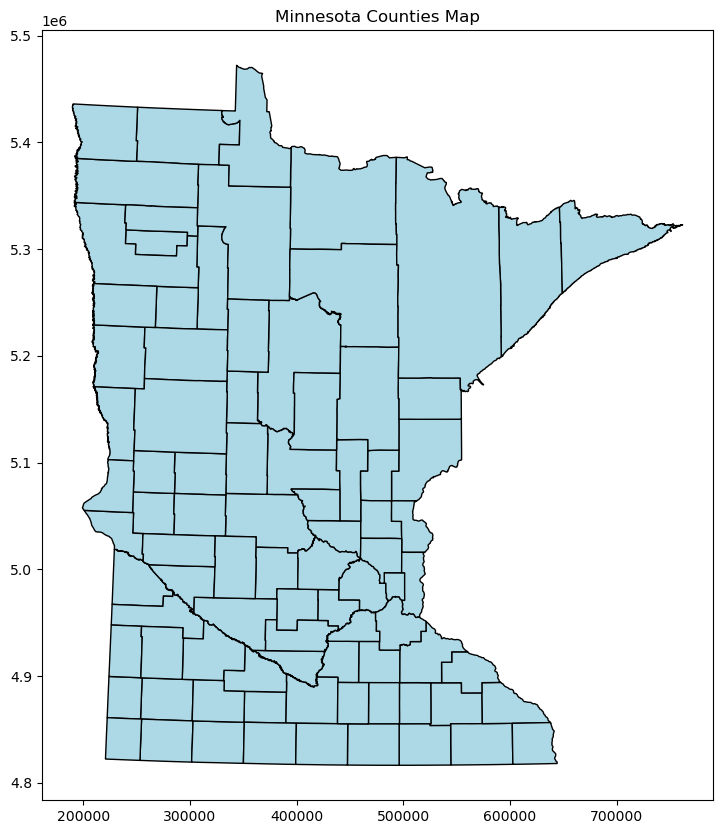

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import folium 
import matplotlib.pyplot as plt

# URL to Minnesota counties shapefile for geo location

mn_counties = gpd.read_file('Minnesota/mn_shp_bdry_counties.zip')
mn_counties.head(5)

fig, ax = plt.subplots(figsize=(10, 10))
mn_counties.plot(ax=ax, edgecolor='black', color='lightblue')
ax.set_title('Minnesota Counties Map')
plt.show()





In [1]:
# import counties
import ee

ee.Authenticate()
ee.Initialize()

ee_counties = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '27'))

ee_counties

In [5]:
import ee
import pandas as pd
import numpy as np
import geemap
import itertools
from tqdm import tqdm

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define years and months
years = list(range(2000, 2023))
months = list(range(2, 9))  # Feb to Aug

# Modified function to extract averages for all bands using TIGER counties for Minnesota
def get_county_averages_multi_band(collection, start_date, end_date):
    image = collection.filterDate(start_date, end_date).mean()
    
    # Get list of all band names
    band_names = image.bandNames().getInfo()
     
    # Load Minnesota counties from TIGER dataset
    ee_counties = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '27'))
    
    # Reduce regions
    stats = image.reduceRegions(collection=ee_counties, reducer=ee.Reducer.mean(), scale=1000)
    results = stats.getInfo()
    
    data = []
    for feature in results['features']:
        props = feature['properties']
        row = {
            'fips': props['GEOID'],
            'county_name': props['NAME']
        }
        for band in band_names:
            row[band] = props.get(band, np.nan)
        data.append(row)
    return pd.DataFrame(data)

# GLDAS Collection (all 36 bands)
gldas = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H')

# Initialize dataframe for GLDAS data (all bands)
gldas_data = pd.DataFrame()

# Calculate total iterations for progress bar
total_iterations = len(years) * len(months)

# Loop over years and months to collect data with progress bar
for year, month in tqdm(itertools.product(years, months), total=total_iterations, desc="Downloading GLDAS Data"):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    
    # Get averages for all bands
    monthly_data = get_county_averages_multi_band(gldas, start_date, end_date)
    
    # Add year and month columns
    monthly_data['year'] = year
    monthly_data['month'] = month
    
    # Append to main dataframe
    gldas_data = pd.concat([gldas_data, monthly_data], ignore_index=True)



# Optional: Visualize first image (example for one band)
Map = geemap.Map()
vis_params = {'bands': ['SoilMoi0_10cm_inst'], 'min': 0, 'max': 0.3}
image = gldas.first()
Map.addLayer(image, vis_params, 'First Image')
Map

# Display or save the data
print(gldas_data.head())
gldas_data.to_csv('gldas_all_bands_data.csv', index=False)

AttributeError: module 'ee.data' has no attribute '_credentials'

In [16]:
import ee
import geemap

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()


# Calculate total iterations for progress bar
total_iterations = len(years) * len(months)


# Display the first image from GLDAS for verification, adding layers for all 36 bands
Map = geemap.Map(center=[46.4, -94.5], zoom=6)  # Center on Minnesota

# Define band-specific min/max from dataset documentation (estimated values)
band_vis_dict = {
    'Albedo_inst': {'min': 4.99, 'max': 82.25},
    'AvgSurfT_inst': {'min': 187.48, 'max': 1323.35},
    'CanopInt_inst': {'min': 0, 'max': 0.5},
    'ECanop_tavg': {'min': 0, 'max': 1273.66},
    'ESoil_tavg': {'min': 0, 'max': 2275.63},
    'Evap_tavg': {'min': 0, 'max': 0.002},
    'LWdown_f_tavg': {'min': 26.85, 'max': 600.9},
    'Lwnet_tavg': {'min': -13792.7, 'max': 196.97},
    'PotEvap_tavg': {'min': -227.75, 'max': 18977.9},
    'Psurf_f_inst': {'min': 44063.1, 'max': 108344},
    'Qair_f_inst': {'min': -0.02, 'max': 0.07},
    'Qg_tavg': {'min': -552.64, 'max': 1538.41},
    'Qh_tavg': {'min': -1005.15, 'max': 18190.6},
    'Qle_tavg': {'min': -227.75, 'max': 5072.25},
    'Qs_acc': {'min': 0, 'max': 170.93},
    'Qsb_acc': {'min': 0, 'max': 50.6},
    'Qsm_acc': {'min': 0, 'max': 42.87},
    'Rainf_f_tavg': {'min': 0, 'max': 0.01},
    'Rainf_tavg': {'min': 0, 'max': 0.01},
    'RootMoist_inst': {'min': 2, 'max': 949.6},
    'SWE_inst': {'min': 0, 'max': 120787},
    'SWdown_f_tavg': {'min': -56.93, 'max': 30462.8},
    'SnowDepth_inst': {'min': 0, 'max': 301.96},
    'Snowf_tavg': {'min': 0, 'max': 0.009},
    'SoilMoi0_10cm_inst': {'min': 1.99, 'max': 47.59},
    'SoilMoi10_40cm_inst': {'min': 5.99, 'max': 142.8},
    'SoilMoi40_100cm_inst': {'min': 11.99, 'max': 285.6},
    'SoilMoi100_200cm_inst': {'min': 20, 'max': 476},
    'SoilTMP0_10cm_inst': {'min': 221.98, 'max': 377.5},
    'SoilTMP10_40cm_inst': {'min': 227.43, 'max': 319.44},
    'SoilTMP40_100cm_inst': {'min': 232.97, 'max': 316.2},
    'SoilTMP100_200cm_inst': {'min': 238.52, 'max': 314.11},
    'Swnet_tavg': {'min': -48.96, 'max': 23741.3},
    'Tair_f_inst': {'min': 206.8, 'max': 327.66},
    'Tveg_tavg': {'min': 0, 'max': 3455.14},
    'Wind_f_inst': {'min': 0, 'max': 57.7}
}

# Get a sample image (first from a specific date)
sample_gldas = gldas_data
image = sample_gldas.first()

# Get band names
band_names = image.bandNames().getInfo()

# Add a layer for each band with band-specific vis params
palette = ['blue', 'cyan', 'green', 'yellow', 'red']  # Common palette for visualization
for band in band_names:
    if band in band_vis_dict:
        vis_params = {
            'bands': [band],
            'min': band_vis_dict[band]['min'],
            'max': band_vis_dict[band]['max'],
            'palette': palette
        }
        Map.addLayer(image, vis_params, band)

# Print image info
print("First GLDAS Image Info:")
pprint.pprint(image.getInfo())

# Display the interactive map
display(Map)

AttributeError: module 'ee.data' has no attribute '_credentials'

In [17]:
gldas_data.head(10)

,fips,county_name,Albedo_inst,AvgSurfT_inst,CanopInt_inst,ECanop_tavg,ESoil_tavg,Evap_tavg,LWdown_f_tavg,Lwnet_tavg,...,SoilTMP0_10cm_inst,SoilTMP100_200cm_inst,SoilTMP10_40cm_inst,SoilTMP40_100cm_inst,Swnet_tavg,Tair_f_inst,Tveg_tavg,Wind_f_inst,year,month
0,27073,Lac qui Parle,45.628617,268.901502,0.170420,0.094085,4.831143,0.000005,259.458295,-35.648687,...,268.826365,274.867397,268.464492,269.632552,50.665452,269.784213,0.000795,4.537589,2000,2
1,27153,Todd,56.148677,265.590273,0.206198,0.078237,2.168450,0.000003,249.600736,-31.664551,...,266.971425,274.416129,267.790632,268.883070,41.925469,266.853667,0.000045,4.124489,2000,2
2,27001,Aitkin,50.244838,264.970104,0.175215,0.102708,2.679327,0.000004,243.178305,-34.681887,...,267.489019,273.978808,268.936852,270.274443,46.623340,266.555530,0.000008,3.688226,2000,2
3,27057,Hubbard,48.491914,264.914661,0.210605,0.095990,2.421774,0.000003,244.762518,-32.901821,...,266.858855,273.354544,268.066121,269.214886,48.109217,266.127134,0.000000,3.601552,2000,2
4,27063,Jackson,50.091128,269.441418,0.199066,0.278989,5.146278,0.000006,262.570152,-35.010630,...,269.274922,274.986025,268.878458,269.894368,48.702200,270.714126,0.003282,4.948826,2000,2
5,27121,Pope,55.467326,266.598502,0.172878,0.066571,3.006990,0.000004,253.792306,-31.727923,...,267.257765,274.264386,267.444965,268.740709,41.898602,267.727905,0.000108,4.451930,2000,2
6,27133,Rock,42.564482,270.324059,0.274374,0.976635,7.152185,0.000007,261.111781,-40.138001,...,270.061416,274.832986,269.461307,270.602765,57.622371,271.552264,0.028276,4.929492,2000,2
7,27161,Waseca,60.938878,268.337954,0.212586,0.085138,3.804249,0.000004,261.592485,-31.446839,...,268.951645,274.711281,269.326730,270.336344,38.937740,269.758461,0.000332,4.627950,2000,2
8,27033,Cottonwood,51.272916,269.115287,0.200030,0.207269,4.903958,0.000005,262.924099,-33.385060,...,269.003126,275.162304,268.712094,270.027996,45.010653,270.378330,0.001719,4.842022,2000,2
9,27071,Koochiching,45.337337,263.930224,0.244704,0.173364,2.479977,0.000004,234.853488,-37.676858,...,266.478099,274.032957,268.054139,269.860281,53.137898,265.173850,0.000000,3.358798,2000,2


In [19]:
!pip install tensorflow

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 2.4/332.0 MB 14.1 MB/s eta 0:00:24
    --------------------------------------- 5.2/332.0 MB 14.3 MB/s eta 0:00:23
    --------------------------------------- 8.1/332.0 MB 14.3 MB/s eta 0:00:23
   - -------------------------------------- 11.3/332.0 MB 14.3 MB/s eta 0:00:23
   - -------------------------------------- 14.2/332.0 MB 14.3 MB/s eta 0:00:23
   -- ------------------------------------- 17.0/332.0 MB 14.3 MB/s eta 0:00:22
   -- ------------------------------------- 20.2/332.0 MB 14.3 MB/s eta 0:00:22
   -- ------------------------------------- 23.1/332.0 MB 14.4 MB/s eta 0:00:22
   --- ------------------------------------ 26.2/332.0 MB 14.3 MB/s eta 0:00:22
   --- ------------------------------------ 29.1/332.0 MB 14.3 MB/s eta 0:00:22
   --- ------------------------------------ 32.0/332.0 MB 14.3 MB/s eta 0:00:21
   ---- ----------------------------------- 34.9/332

In [22]:
gldas_path = 'Data/gldas_all_bands_data.csv'  
corn_prod_path = 'Data/mn_county_corn_production_2000_2022.csv'

In [27]:
data.head(5)

,year,fips,sequence,production
0,2000,27003,"[[58.361777093944845, 266.5877660170595, 0.240...",795600.0
1,2000,27005,"[[55.58346376470553, 264.6142973895659, 0.1956...",1449600.0
2,2000,27007,"[[48.49849138094897, 264.2412504187317, 0.2317...",78400.0
3,2000,27009,"[[58.02384233632291, 265.94676086831635, 0.195...",4967400.0
4,2000,27011,"[[45.956175943807885, 268.1887774500573, 0.150...",9841800.0


In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Define paths
gldas_path = 'Data/gldas_all_bands_data.csv'  
corn_prod_path = 'Data/mn_county_corn_production_2000_2022.csv'

# Load GLDAS data
gldas_df = pd.read_csv(gldas_path)

# Load corn production data
corn_df = pd.read_csv(corn_prod_path)

# Preprocess corn production: melt to long format
corn_df = corn_df.melt(id_vars=['fips', 'county_name'], var_name='year', value_name='production')
corn_df['year'] = corn_df['year'].astype(int)
corn_df['production'] = pd.to_numeric(corn_df['production'], errors='coerce')
corn_df = corn_df.dropna(subset=['production'])
corn_df['fips'] = corn_df['fips'].astype(str).str.zfill(5)

# Clip outliers in production (99th percentile)
production_cap = corn_df['production'].quantile(0.99)
corn_df['production'] = corn_df['production'].clip(upper=production_cap)

# Preprocess GLDAS: ensure fips is string, filter years 2000-2022
gldas_df['fips'] = gldas_df['fips'].astype(str).str.zfill(5)
gldas_df = gldas_df[gldas_df['year'].between(2000, 2022)]

# Get list of 36 bands
band_columns = [col for col in gldas_df.columns if col not in ['fips', 'county_name', 'year', 'month']]
assert len(band_columns) == 36, f"Expected 36 bands, found {len(band_columns)}"

# Handle missing values: fill with mean per band
for band in band_columns:
    gldas_df[band] = gldas_df[band].fillna(gldas_df[band].mean())

# Create time-series data
gldas_df = gldas_df.sort_values(['year', 'fips', 'month'])

def group_to_sequence(group):
    if len(group) != 7:
        return None
    sequence = group[band_columns].values  # Shape: (7, 36)
    return sequence

sequences = gldas_df.groupby(['year', 'fips']).apply(group_to_sequence).reset_index(name='sequence')
sequences = sequences.dropna()

# Merge with corn production targets
data = pd.merge(sequences, corn_df[['year', 'fips', 'production']], on=['year', 'fips'])

# Prepare X and y
X = np.stack(data['sequence'].values)  # Shape: (samples, 7 timesteps, 36 features)
y = data['production'].values

# Normalize features
scalers = {}
for i in range(X.shape[2]):
    scalers[i] = StandardScaler()
    X[:, :, i] = scalers[i].fit_transform(X[:, :, i].reshape(-1, 1)).reshape(X.shape[:2])

# Log-transform target
y = np.log1p(y)

# Split train/test: 2000-2020 train, 2021-2022 test
train_mask = data['year'] <= 2020
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

data.to_csv('gldas_all_bands_with_target.csv', index=False)

# Verify input shape
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")




X_train shape: (1564, 7, 36), y_train shape: (1564,)
X_test shape: (154, 7, 36), y_test shape: (154,)


Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 182.9039 - mae: 13.3282 - val_loss: 93.4036 - val_mae: 9.5300
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.9244 - mae: 5.1209 - val_loss: 9.9535 - val_mae: 2.4648
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2329 - mae: 2.3922 - val_loss: 3.0219 - val_mae: 1.4502
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3891 - mae: 1.8680 - val_loss: 2.3762 - val_mae: 1.1828
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4407 - mae: 1.6924 - val_loss: 1.9462 - val_mae: 1.0821
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9542 - mae: 1.5807 - val_loss: 1.7661 - val_mae: 1.0376
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5424 - mae: 1.5258 - val_loss: 1.5175 - val_mae: 0.9750
Epoch 8/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6745 - mae: 1.5223 - val_loss: 1.4067 - val_mae: 0.9422
Epoch 9/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

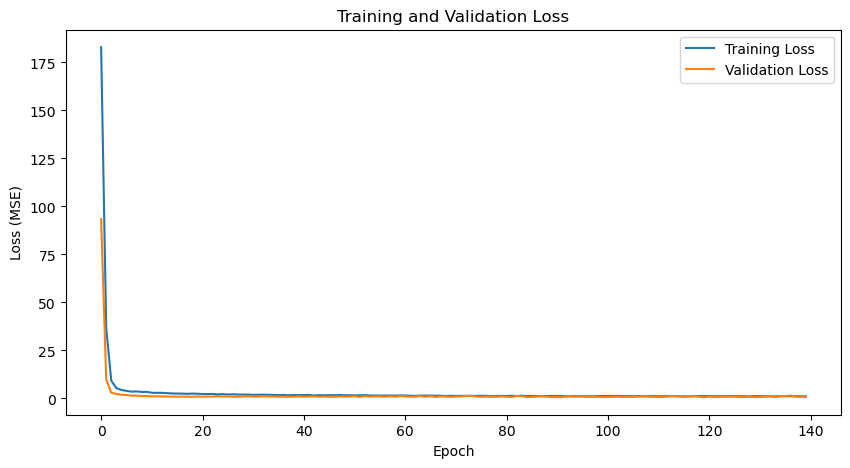

In [36]:
# Build 1D CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(7, 36), padding='same', kernel_regularizer=l2(1e-6)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2, padding='same', kernel_regularizer=l2(1e-6)))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(1))  # Regression output

# Compile
optimizer = Adam(learning_rate=0.00025)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, min_delta=0.001)

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test set (inverse transform)
y_pred = model.predict(X_test)
y_pred_inv = np.expm1(y_pred)  # Inverse log1p
y_test_inv = np.expm1(y_test)

# Calculate R² and MAPE
r2 = r2_score(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
print(f"Test R² Score: {r2}")
print(f"Test MAPE: {mape}%")

# Print sample predictions
print("Sample Predictions:")
for i in range(min(5, len(y_test_inv))):
    print(f"Actual: {y_test_inv[i]:.2f}, Predicted: {y_pred_inv[i][0]:.2f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Save model in native Keras format
model.save('cnn_corn_yield_model.keras')

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Define paths
gldas_path = 'Data/gldas_all_bands_data.csv'  
corn_prod_path = 'Data/mn_county_corn_production_2000_2022.csv'

# Load GLDAS data
gldas_df = pd.read_csv(gldas_path)

# Load corn production data
corn_df = pd.read_csv(corn_prod_path)

# Preprocess corn production: melt to long format
corn_df = corn_df.melt(id_vars=['fips', 'county_name'], var_name='year', value_name='production')
corn_df['year'] = corn_df['year'].astype(int)
corn_df['production'] = pd.to_numeric(corn_df['production'], errors='coerce')
corn_df = corn_df.dropna(subset=['production'])
corn_df['fips'] = corn_df['fips'].astype(str).str.zfill(5)

# Clip outliers (95th percentile)
production_cap = corn_df['production'].quantile(0.95)
corn_df['production'] = corn_df['production'].clip(upper=production_cap)

# Preprocess GLDAS: ensure fips is string, filter years 2000-2022
gldas_df['fips'] = gldas_df['fips'].astype(str).str.zfill(5)
gldas_df = gldas_df[gldas_df['year'].between(2000, 2022)]

# Print data summary
print(f"GLDAS unique counties: {len(gldas_df['fips'].unique())}")
print(f"Corn production unique counties: {len(corn_df['fips'].unique())}")
print(f"GLDAS samples: {len(gldas_df)}, Corn samples: {len(corn_df)}")

# Get list of 36 bands
band_columns = [col for col in gldas_df.columns if col not in ['fips', 'county_name', 'year', 'month']]
assert len(band_columns) == 36, f"Expected 36 bands, found {len(band_columns)}"

# Handle missing values
for band in band_columns:
    gldas_df[band] = gldas_df[band].fillna(gldas_df[band].mean())

# Feature selection with Random Forest
def select_top_features(X, y, band_columns, n_features=15):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    X_flat = X.reshape(X.shape[0], -1)  # Flatten to (samples, 7*36)
    rf.fit(X_flat, y)
    importances = rf.feature_importances_
    feature_names = [f"{band}_m{month}" for month in range(2, 9) for band in band_columns]
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
    top_features = feature_importance.groupby(feature_names).sum().nlargest(n_features, 'importance').index
    selected_bands = set(f.split('_m')[0] for f in top_features)
    return list(selected_bands)

# Create time-series data
gldas_df = gldas_df.sort_values(['year', 'fips', 'month'])

def group_to_sequence(group, selected_bands):
    if len(group) != 7:
        return None
    sequence = group[selected_bands].values  # Shape: (7, n_selected_bands)
    return sequence

# Initial data preparation for feature selection
sequences = gldas_df.groupby(['year', 'fips']).apply(lambda g: group_to_sequence(g, band_columns)).reset_index(name='sequence')
sequences = sequences.dropna()
data = pd.merge(sequences, corn_df[['year', 'fips', 'production']], on=['year', 'fips'])
X = np.stack(data['sequence'].values)
y = data['production'].values

# Select top 15 bands
selected_bands = select_top_features(X, y, band_columns, n_features=15)
print(f"Selected bands: {selected_bands}")

# Recreate sequences with selected bands
sequences = gldas_df.groupby(['year', 'fips']).apply(lambda g: group_to_sequence(g, selected_bands)).reset_index(name='sequence')
sequences = sequences.dropna()
data = pd.merge(sequences, corn_df[['year', 'fips', 'production']], on=['year', 'fips'])

# Prepare X and y
X = np.stack(data['sequence'].values)  # Shape: (samples, 7 timesteps, n_selected_bands)
y = data['production'].values

# Normalize features
scalers = {}
for i in range(X.shape[2]):
    scalers[i] = StandardScaler()
    X[:, :, i] = scalers[i].fit_transform(X[:, :, i].reshape(-1, 1)).reshape(X.shape[:2])

# Scale target with MinMaxScaler
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Split train/test
train_mask = data['year'] <= 2020
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

# Verify shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Build simplified CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, input_shape=(7, len(selected_bands)), padding='same', kernel_regularizer=l2(1e-5)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, padding='same', kernel_regularizer=l2(1e-5)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(1))

# Compile
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_r2_scores = []
fold_mape_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\nTraining Fold {fold + 1}")
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    # Train
    history = model.fit(X_fold_train, y_fold_train, epochs=200, batch_size=32, validation_data=(X_fold_val, y_fold_val),
                       callbacks=[early_stopping, reduce_lr], verbose=1)

    # Evaluate fold
    y_pred_val = model.predict(X_fold_val)
    y_pred_val_inv = y_scaler.inverse_transform(y_pred_val)
    y_fold_val_inv = y_scaler.inverse_transform(y_fold_val.reshape(-1, 1))
    fold_r2 = r2_score(y_fold_val_inv, y_pred_val_inv)
    fold_mape = np.mean(np.abs((y_fold_val_inv - y_pred_val_inv) / y_fold_val_inv)) * 100
    fold_r2_scores.append(fold_r2)
    fold_mape_scores.append(fold_mape)
    print(f"Fold {fold + 1} R²: {fold_r2:.4f}, MAPE: {fold_mape:.2f}%")

print(f"\nMean CV R²: {np.mean(fold_r2_scores):.4f} ± {np.std(fold_r2_scores):.4f}")
print(f"Mean CV MAPE: {np.mean(fold_mape_scores):.2f}% ± {np.std(fold_mape_scores):.2f}%")

# Final training on full train set
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"\nTest Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test set
y_pred = model.predict(X_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate R² and MAPE
r2 = r2_score(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
print(f"Test R² Score: {r2}")
print(f"Test MAPE: {mape}%")

# Print sample predictions with county info
print("\nSample Predictions:")
test_data = data[~train_mask].reset_index(drop=True)
for i in range(min(5, len(y_test_inv))):
    county = test_data.loc[i, 'fips']
    year = test_data.loc[i, 'year']
    print(f"County: {county}, Year: {year}, Actual: {y_test_inv[i]:.2f}, Predicted: {y_pred_inv[i][0]:.2f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Save model
model.save('cnn_corn_yield_model.keras')

GLDAS unique counties: 87
Corn production unique counties: 85
GLDAS samples: 14007, Corn samples: 1868
Selected bands: ['Wind_f_inst', 'Albedo_inst', 'Qg_tavg', 'ESoil_tavg', 'Psurf_f_inst']
X_train shape: (1564, 7, 5), y_train shape: (1564,)
X_test shape: (154, 7, 5), y_test shape: (154,)

Training Fold 1
Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7023 - mae: 0.6411 - val_loss: 0.2388 - val_mae: 0.3895 - learning_rate: 5.0000e-04
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2311 - mae: 0.3666 - val_loss: 0.1757 - val_mae: 0.3349 - learning_rate: 5.0000e-04
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1264 - mae: 0.2753 - val_loss: 0.1577 - val_mae: 0.3172 - learning_rate: 5.0000e-04
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0945 - mae: 0.2388 - val_loss: 0.1380 - val_mae: 0.2943 - learning_rate: 5.0000e-04
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0824 - mae: 0.2216 - val_loss: 0.1062 - val_mae: 0

TypeError: unsupported format string passed to numpy.ndarray.__format__